In [2]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *

from activation_maximization import showall, getAM

from keras import backend as K

import cv2

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

In [3]:
model = VGG16(weights='imagenet',
				  include_top=False,
				  input_shape=( 174, 174, 3))

In [4]:
k = 20 # Top 10% highest l2-magnitude filters and channels

In [5]:
conv_layers = []
for l in model.layers:
	if 'conv2d' in str(type(l)).lower():
		conv_layers.append(l)

a_count= []
s_count= []

full_a_a = []
full_a_s = []
full_s_a = []
full_s_s = []

l_num = 2
l = conv_layers[l_num]

print(f" ============ LAYER {l_num} , {l.name}==================")
top10F=topKfilters(model,l_num, k=k)
print(l_num, top10F)
filters = get_filter(model, l_num)[:,:,:, top10F]
s, a = getSymAntiSymTF(filters)
a_e = reduce_euclidean_norm(a, axis=[0,1])**2
#print(a_mag.shape)

s_e = reduce_euclidean_norm(s, axis=[0,1])**2
beta = tf.reduce_mean(a_e/(s_e+a_e), axis=0)


antisym_filters = tf.reshape(tf.where(beta >= 0.5), [-1])
sym_filters = tf.reshape(tf.where(beta < 0.5), [-1])

a_count.append(len(antisym_filters))
s_count.append(len(sym_filters))

#print(antisym_filters)

'''a_mag = reduce_euclidean_norm(a, axis=[0,1, 2])**2
a_mag = a_mag[top10F]
s_mag = reduce_euclidean_norm(s, axis=[0,1, 2])**2
s_mag = s_mag[top10F]'''

a_a = 0
a_s = 0
s_a = 0
s_s = 0

prv_top10KF = topKfilters(model, l_num-1, k=k)
prv_filters = get_filter(model, l_num-1)[:,:,:, prv_top10KF]
prv_s, prv_a = getSymAntiSymTF(prv_filters)
prv_a_mag = reduce_euclidean_norm(prv_a, axis=[0,1])**2
prv_s_mag = reduce_euclidean_norm(prv_s, axis=[0,1])**2
prv_avg_amag = reduce_mean(prv_a_mag, axis=0).numpy()
prv_avg_smag = reduce_mean(prv_s_mag, axis=0).numpy()
prv_beta = reduce_mean(prv_a_mag/(prv_a_mag+prv_s_mag), axis=0).numpy()
prv_antisym_filters = list(np.array(topKfilters(model, l_num-1, k=100))[[tf.reshape(tf.where(prv_beta >= 0.5), (-1))]])
prv_sym_filters = list(np.array(topKfilters(model, l_num-1, k=100))[[tf.reshape(tf.where(prv_beta < 0.5), (-1))]])
for i, idx in enumerate([17]) :
	#print("Filter ", idx , " : ", topKchannels(l_num+1,idx),"--->",set(topKchannels(l_num+1,idx)).intersection(top10F))
	#Is this filter symetric or antisymmetric ?
	is_anti = beta[i] >= 0.5
	print(is_anti)
	#print()
	# Out of its top-k connections, how many inputs are comming from sym-filters, 
	#                               how many inputs are comming from antisym-filters?

	top_k_connections = list(set(topKchannels(model,l_num,idx, k=k)).intersection(prv_top10KF))
	print("TKC",top_k_connections)
	#Check : does top_k_connections lie in antisym_filters or in sym_filters (or neither) ?  
	#print (top_k_connections, antisym_filters.shape)
	#print(tf.squeeze(antisym_filters) )

	#print("HERE" , set(tf.squeeze(antisym_filters).numpy()).intersection(set(top_k_connections)))
	#print("HERE" , set(tf.squeeze(sym_filters).numpy()).intersection(set(top_k_connections)))
	if is_anti: 
		a_a += len(list(set(prv_antisym_filters).intersection(set(top_k_connections))))
		print(idx, "Anti -> Anti : ", list(set(prv_antisym_filters).intersection(set(top_k_connections))))
		s_a += len(list(set(prv_sym_filters).intersection(set(top_k_connections))))
		print(idx,"Sym -> Anti : ", list(set(prv_sym_filters).intersection(set(top_k_connections))))

	else:
		a_s += len(list(set((prv_antisym_filters)).intersection(set(top_k_connections))))
		print(idx, "Anti -> Sym : ", list(set((prv_antisym_filters)).intersection(set(top_k_connections))))
		s_s += len(list(set((prv_sym_filters)).intersection(set(top_k_connections))))
		print(idx, "Sym ->  Sym : ", list(set((prv_sym_filters)).intersection(set(top_k_connections))))

num_connections = a_a+a_s+s_a+s_s
full_a_a.append(a_a/num_connections)
full_a_s.append(a_s/num_connections)
full_s_a.append(s_a/num_connections)
full_s_s.append(s_s/num_connections)

print("A -> A ",  a_a)
print("A -> S ",  a_s)
print("S -> A ",  s_a)
print("S -> S ",  s_s)
print(top_k_connections)




 ============ LAYER 2 , block2_conv1==================
2 [3, 12, 32, 114, 56, 70, 102, 107, 54, 80, 86, 65, 71, 125, 104, 97, 26, 82, 88, 72, 122, 17, 30, 41, 73]


c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel_launcher.py:55: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel_launcher.py:56: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


tf.Tensor(True, shape=(), dtype=bool)
TKC [19, 29, 30, 55]
17 Anti -> Anti :  [19, 29, 30, 55]
17 Sym -> Anti :  []
A -> A  4
A -> S  0
S -> A  0
S -> S  0
[19, 29, 30, 55]


In [66]:
def plotAntiPlane(model, layer, f_num, ax,n, plot=None):

	ax.set_facecolor("#E5E5E5")
	#ax.set_edgecolor("white")
	conv_layers = []
	filters = get_filter(model, layer)

	theta = getSobelTF(filters)
	print(filters.shape)
	s, a = getSymAntiSymTF(filters)
	a_mag = reduce_euclidean_norm(a, axis=[0,1])
	s_mag = reduce_euclidean_norm(s, axis=[0,1])

	mag = reduce_euclidean_norm(filters, axis=[0,1])

	#x =a_mag[:,f_num]*np.cos((theta[:,f_num]))
	#y = a_mag[:,f_num]*np.sin((theta[:,f_num]))


	x =(a_mag[:,f_num]*np.cos((theta[:,f_num]))).numpy()
	y =( a_mag[:,f_num]*np.sin((theta[:,f_num]))).numpy()
	print("X", x.shape)
	print("PLOT", plot)


	print("X", x)

	lim =np.max(np.abs(mag[:, f_num]))    
	lim*= 1.1

	cov = np.cov([x,y])
	print("COV", cov)
	e_val, e_vec = np.linalg.eig(cov)
	e_vec = e_vec[:, np.argmax(e_val)]
	e_val = np.max(e_val)
	if np.sign(e_vec[0]) != np.sign(x[np.argmax(np.abs(x))]):
		e_vec *= -1
	#print(e_val, e_vec)

	#ax = fig.add_subplot(gs1[l_num,i])
	ax.set_xlim(-lim, lim)
	ax.set_ylim(-lim, lim)
	if plot is not None:
		x = x[plot]
		y = y[plot]
	print("X", x.shape)

	ax.scatter(x,y, s=30, color='#E24A33')
	ax.set_box_aspect(1)

	ax.set_xticks([])
	ax.set_yticks([])
	ax.set_aspect('equal')
	ax.collections[0].set_rasterized(True)

	#ax.arrow(0, 0, e_vec[0]/lim, e_vec[1]/lim, color="black", linestyle="--")
	#ax.arrow(0, 0, e_vec[0]*e_val*5, e_vec[1]*e_val*5, color="black", linestyle="--")
	ax.annotate("", xy=(e_vec[0]*e_val, e_vec[1]*e_val), xytext=(0, 0), 
				arrowprops=dict(arrowstyle="->",  color='black', lw=None))
	
	print(f_num,  np.arctan2(e_vec[1], e_vec[0]))
 
	return np.mean((a_mag[:,f_num]**2)/(mag[:,f_num]**2)), np.arctan2(e_vec[1], e_vec[0])


In [7]:
def getDominantAngle(filters):
	theta = getSobelTF(filters)
	print(filters.shape)
	s, a = getSymAntiSymTF(filters)
	a_mag = reduce_euclidean_norm(a, axis=[0,1])
	s_mag = reduce_euclidean_norm(s, axis=[0,1])

	mag = reduce_euclidean_norm(filters, axis=[0,1])


	domTheta = []
	for i in range(filters.shape[-1]):
		x =(a_mag[:,i]*np.cos((theta[:,i]))).numpy()
		y =( a_mag[:,i]*np.sin((theta[:,i]))).numpy()


		cov = np.cov([x,y])
		e_val, e_vec = np.linalg.eig(cov)
		e_vec = e_vec[:, np.argmax(e_val)]
		e_val = np.max(e_val)
		if np.sign(e_vec[0]) != np.sign(x[np.argmax(np.abs(x))]):
			e_vec *= -1
		domTheta.append(np.arctan2(e_vec[1], e_vec[0]))
	#x =a_mag[:,f_num]*np.cos((theta[:,f_num]))
	#y = a_mag[:,f_num]*np.sin((theta[:,f_num]))

	return np.array(domTheta)

In [8]:
getSobelTF(get_filter(model, 1))[10, 19]

0.03944515

In [9]:
getDominantAngle(get_filter(model, 0))[10]

(3, 3, 3, 64)


1.6116091593884714

(3, 3, 128, 128)
252
Topk [ 56  55 125 113  81 100  42  14  10  12]
(3, 3, 128, 256)
X (128,)
PLOT [56]
X [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.27511185 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.      

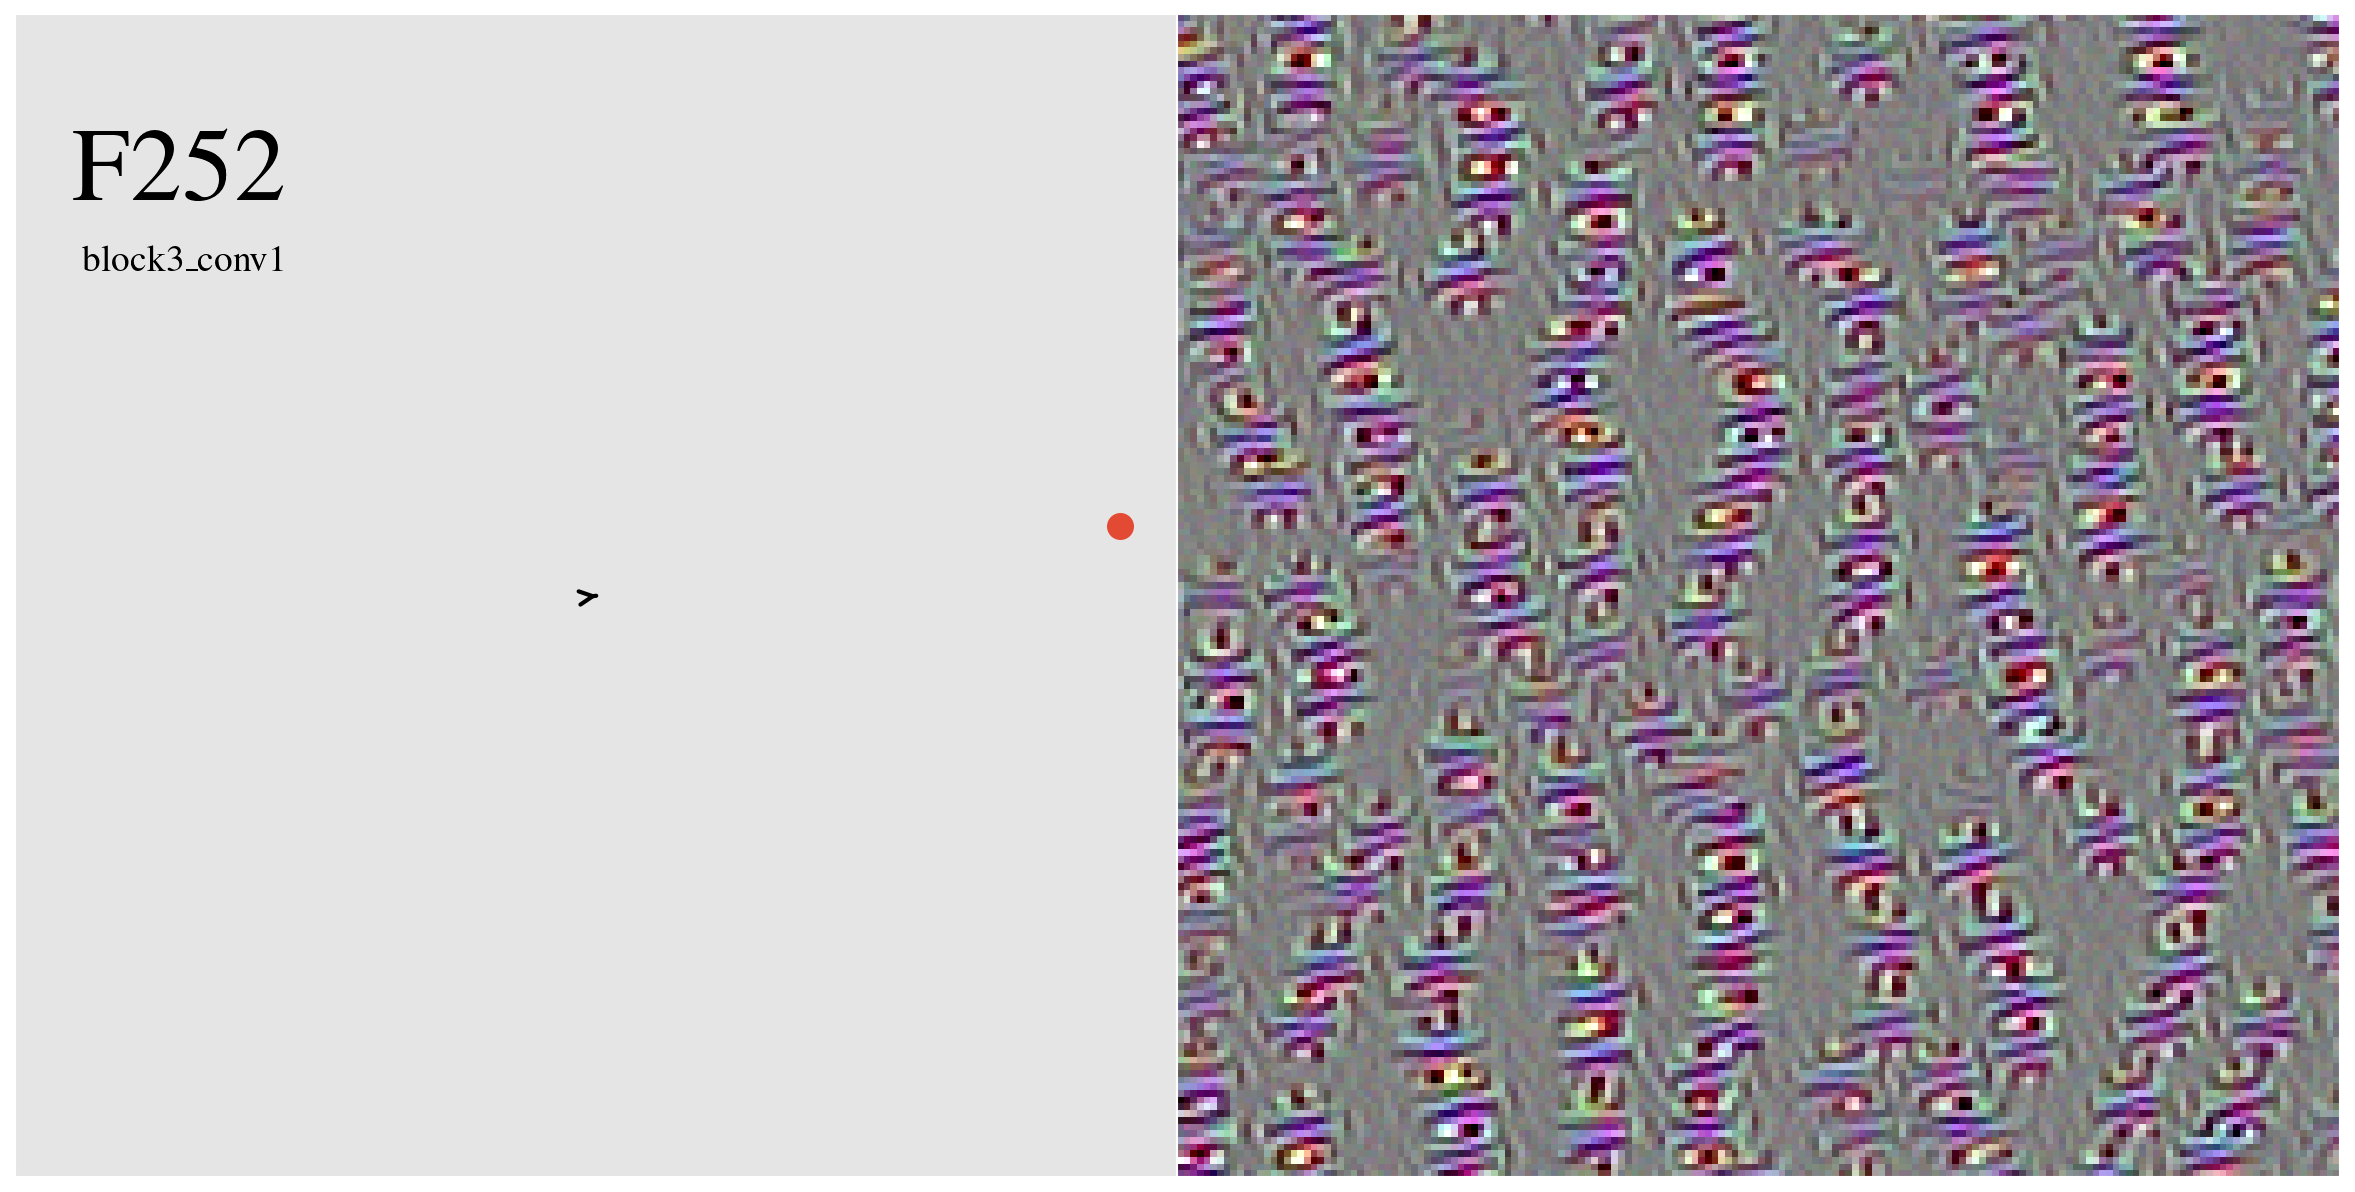

In [67]:
plt.rcParams.update({'figure.dpi': '300'})

plt.rcParams["axes.facecolor"] = "E5E5E5"
plt.rcParams["axes.edgecolor"] = "white"
plt.rcParams["text.usetex"] =  True
#[101, 105, 10, 41, 12, 14, 16, 113, 18, 19]
model = VGG16(weights='imagenet',
		  include_top=False,
		  input_shape=( 174, 174, 3))



conv_layers = []
for l in model.layers:
	if 'conv2d' in str(type(l)).lower():
		conv_layers.append(l)

layer_filter = {4:[252]} # {1: [59,30,29], 2: [56,70,107], 3: [86,85,105,61], 4:[2, 254, 252, 14, 87, 236, 133, 85, 172, 41]}
#K = 3

for LAYER, FILTERS in layer_filter.items(): 
	filtersLp = get_filter(model, LAYER-1)

	domThetaP = getDominantAngle(filtersLp)

	for F in FILTERS:
		filtersL = get_filter(model, LAYER)
		s, a = getSymAntiSymTF(filtersL)
		a_mag = reduce_euclidean_norm(a, axis=[0,1])[:, F]
		thetaL = getSobelTF(filtersL)[:, F]

		s, a = getSymAntiSymTF(filtersLp)
		a_magLp = reduce_mean(reduce_euclidean_norm(a, axis=[0,1]), axis=0)	
		malus = a_mag*(np.cos(domThetaP-thetaL )**2)
		print(F)
		for col in [1]:
			model = VGG16(weights='imagenet',
			include_top=False,
			input_shape=(224, 224, 3))
			
			# Take a filter, and find the top connections to it (top channels that connect to top filters in the previous layer)
			prv_top10KF = topKfilters(model, LAYER-1, k=20)
			top_k_connections = np.array(list(set(prv_top10KF).intersection((topKchannels(model,LAYER,F, k=20)))))    #np.argsort(malus, axis=0)[-10:]   #   
			#prv_filters = get_filter(model, LAYER-1)[:,:,:, top_k_connections]
			ch_mag = reduce_euclidean_norm(filtersL[:,:,top_k_connections, F], axis=[0,1])**2
			idx = list(range(ch_mag.shape[-1]))
			idx = [x for _, x in sorted(zip( ch_mag, idx), reverse=True)]
			top_k_connections = top_k_connections[idx]
			print("Topk", top_k_connections)

			if col==1:
				w,b = model.get_layer(conv_layers[LAYER].name).get_weights()

				top_k_connections = [  56 ]
				mask = np.ones(w.shape, bool)
				mask[: ,:, top_k_connections, :] = False
				w[mask] = 0
				mask = np.ones(b.shape, bool)
				mask[top_k_connections] = False
				b[mask] = 0
				model.get_layer(conv_layers[LAYER].name).set_weights([w,b] )
			'''fig, ax= plt.subplots(1,2,figsize = (10,13))


			plotAntiPlane(model, LAYER, F, ax[0])
			ax[1].imshow(getAM(model, LAYER, F))
			ax[1].set_aspect('equal')
			ax[0].set_aspect('equal')
			ax[0].set_xticks([])
			ax[1].set_xticks([])
			ax[0].set_yticks([])
			ax[1].set_yticks([])
			fig.subplots_adjust(wspace=0, hspace=0)'''

			fig, ax= plt.subplots(1,2,figsize = (10,13))
			beta, theta = plotAntiPlane(model, LAYER, F,  ax[0], n=[10], plot=top_k_connections)
			origAM, scaledAM = getAM(model, LAYER, F )
			ax[1].imshow(scaledAM)
			ax[1].set_aspect('equal')
			ax[0].set_aspect('equal')
			ax[0].set_xticks([])
			ax[1].set_xticks([])
			ax[0].set_yticks([])
			ax[1].set_yticks([])
			fig.subplots_adjust(wspace=0, hspace=0)
			ax[0].text(.05, .78, f"F{F}\\\\[0.2em]\\indent \small{{ {conv_layers[LAYER].name} }}", fontsize=25,
				horizontalalignment='left',
				verticalalignment='bottom',
				transform=ax[0].transAxes)
			if col==0:
				plt.savefig(f"figures/L{LAYER}_F{F}.png",bbox_inches='tight', pad_inches = 0, dpi=200)
			if col==1:
				plt.savefig(f"figures/L{LAYER}_F{F}_top.png",bbox_inches='tight', pad_inches = 0, dpi=200)


In [12]:
get_filter(model, LAYER)[:,:,45, 19]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)

(87, 87)


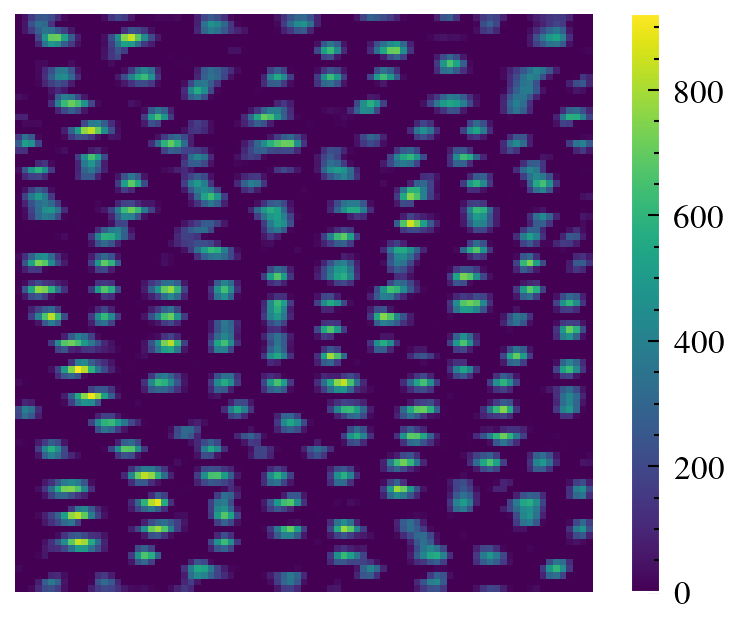

In [50]:
model2 = VGG16(weights='imagenet',
				  include_top=False,
				  input_shape=(174, 174, 3))
conv_layers = []
for l in model2.layers:
	if 'conv2d' in str(type(l)).lower():
		if l.kernel_size == (3,3):
			conv_layers.append(l)

layer = conv_layers[3]

f = K.function([model2.input], [layer.output])
#origAM = origAM[25:-25, 25:-25, :]
filter_activation = f(tf.expand_dims(np.rot90(origAM, axes= [0,1], k=0), 0))[0][0,:,:,56]
print(filter_activation.shape)
filter_activation =  filter_activation

heatmap = cv2.resize(filter_activation, (scaledAM.shape[0], scaledAM.shape[1]))
# Normalize the heatmap between 0 and 1 for visualization
#heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# Convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# Apply the heatmap to the input image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_BONE)

# Superimpose the heatmap on the original image
superimposed_img = cv2.addWeighted(np.flip(scaledAM, axis=-1), 0.3, heatmap, 0.7, 0)

# Display the result
plt.imshow(filter_activation)
plt.axis('off')
plt.colorbar()

plt.show()



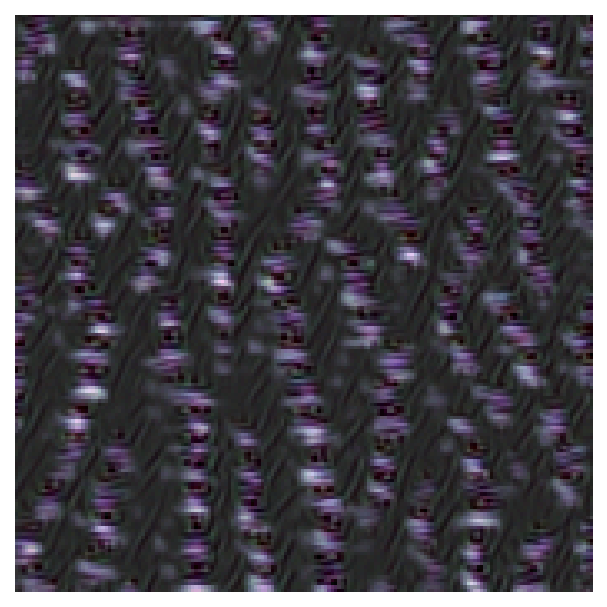

In [14]:
plt.imshow(np.flip(superimposed_img, axis=-1))
plt.axis('off')
plt.show()

